In [16]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [17]:
train_data = torchvision.datasets.MNIST(root='data',
                                        train=True,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='data',
                                       train=False,
                                       transform=torchvision.transforms.ToTensor(),
                                       download=True)

In [18]:
class_names = train_data.classes

In [19]:
img, label = train_data[0]
img.shape

torch.Size([1, 28, 28])

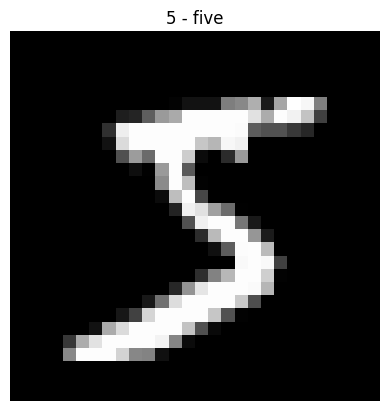

In [20]:
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()

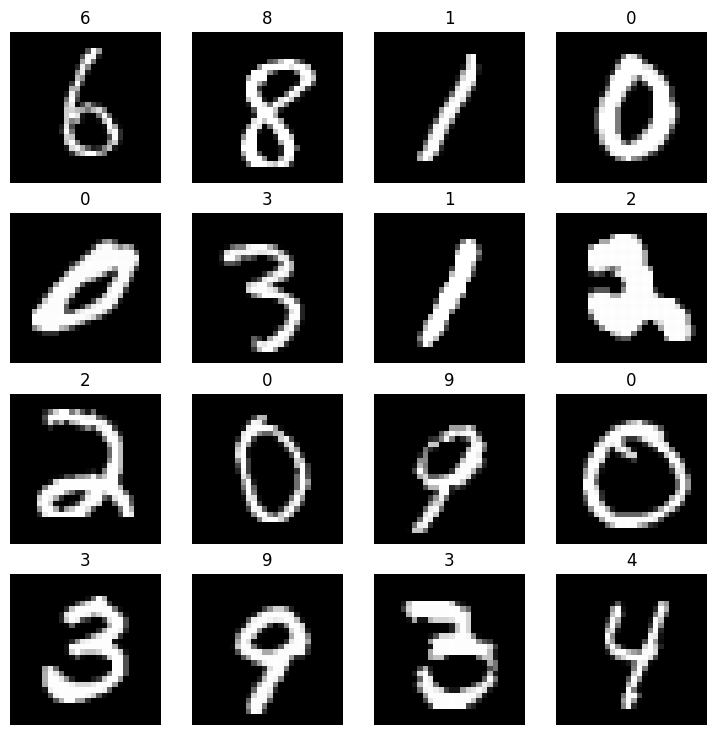

In [21]:
fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4

for i in range(1, (rows*cols)+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')

In [22]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=True)

In [23]:
class MNIST(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
    
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape))
        
    def forward(self, x):
        return self.layer(x)


In [24]:
from pathlib import Path
import requests

url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'

if Path ('helper_functions.py').is_file():
    print('File exists!')
else:
    print('File is downloading')
    requests = requests.get(url)
    with open('helper_functions.py', 'wb') as f:
        f.write(requests.content)

File exists!


In [25]:
from helper_functions import accuracy_fn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    

model = MNIST(input_shape=784,
              hidden_units=10,
              output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)


In [26]:
%%time
from tqdm.auto import tqdm

epochs = 30

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----------')
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f'Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%')

    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%\n')


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 0.5497 | Train acc: 82.73%
Test loss: 0.3283 | Test acc: 90.65%

Epoch: 1
-----------
Train loss: 0.3098 | Train acc: 90.88%
Test loss: 0.2709 | Test acc: 91.70%

Epoch: 2
-----------
Train loss: 0.2797 | Train acc: 91.73%
Test loss: 0.2563 | Test acc: 92.56%

Epoch: 3
-----------
Train loss: 0.2614 | Train acc: 92.22%
Test loss: 0.2588 | Test acc: 92.42%

Epoch: 4
-----------
Train loss: 0.2478 | Train acc: 92.62%
Test loss: 0.2563 | Test acc: 92.50%

Epoch: 5
-----------
Train loss: 0.2396 | Train acc: 92.94%
Test loss: 0.2552 | Test acc: 92.20%

Epoch: 6
-----------
Train loss: 0.2343 | Train acc: 93.12%
Test loss: 0.2396 | Test acc: 92.60%

Epoch: 7
-----------
Train loss: 0.2282 | Train acc: 93.26%
Test loss: 0.2403 | Test acc: 92.79%

Epoch: 8
-----------
Train loss: 0.2244 | Train acc: 93.28%
Test loss: 0.2134 | Test acc: 93.65%

Epoch: 9
-----------
Train loss: 0.2178 | Train acc: 93.49%
Test loss: 0.2469 | Test acc: 92.54%

Epoch: 10
----------

In [27]:
!nvidia-smi

Thu Sep 11 14:08:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8              8W /   95W |     803MiB /   4096MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----